In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/13 - NLP/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/13 - NLP


In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import spacy, nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pickle import dump, load
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub
from functools import partial

In [ ]:
# Define the strategy to use and print the number of devices found
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


# Siamese Network
## Data Processing


In [ ]:
data = pd.read_csv('data/questions.csv')
data = data[~((data['question2'].isnull()) | (data['question1'].isnull()))].reset_index()
data.head()

,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
MAX_LEN = 20
BATCH_SIZE = 64

In [ ]:
N_train = 350000
N_test  = 10 * 1024
data_train = data[ :N_train]
data_val  = data[N_train : N_train + N_test]
data_test  = data[N_train + N_test : N_train + N_test + N_test]

print("Train set:", len(data_train), "Val set:", len(data_val), "Test set:", len(data_test))

Take only the duplicated questions for training our model, so the data generator will produce batches $([q1_1, q1_2, q1_3, ...]$, $[q2_1, q2_2,q2_3, ...])$  where $q1_i$ and $q2_k$ are duplicate if and only if $i = k$.

In [ ]:
td_index = data_train[data_train['is_duplicate'] == 1].index
Q1_train_words = np.array(data_train['question1'][td_index])
Q2_train_words = np.array(data_train['question2'][td_index])
y_train = np.array(data_train['is_duplicate'][td_index])

Q1_val_words = np.array(data_val['question1'])
Q2_val_words = np.array(data_val['question2'])
y_val = np.array(data_val['is_duplicate'])

Q1_test_words = np.array(data_test['question1'])
Q2_test_words = np.array(data_test['question2'])
y_test = np.array(data_test['is_duplicate'])

In [ ]:
# tokenized and one hot with keras text
tokenizer_x = text.Tokenizer(oov_token='UNK')
tokenizer_x.fit_on_texts(np.hstack([Q1_train_words, Q2_train_words]))

# label encoder
Q1_train_token = tokenizer_x.texts_to_sequences(Q1_train_words)
Q2_train_token = tokenizer_x.texts_to_sequences(Q2_train_words)
Q1_val_token = tokenizer_x.texts_to_sequences(Q1_val_words)
Q2_val_token = tokenizer_x.texts_to_sequences(Q2_val_words)
Q1_test_token = tokenizer_x.texts_to_sequences(Q1_test_words)
Q2_test_token = tokenizer_x.texts_to_sequences(Q2_test_words)

# padding
Q1_train_token = sequence.pad_sequences(Q1_train_token, padding='post', truncating='post', maxlen=MAX_LEN)
Q2_train_token = sequence.pad_sequences(Q2_train_token, padding='post', truncating='post', maxlen=MAX_LEN)
Q1_val_token = sequence.pad_sequences(Q1_val_token, padding='post', truncating='post', maxlen=MAX_LEN)
Q2_val_token = sequence.pad_sequences(Q2_val_token, padding='post', truncating='post', maxlen=MAX_LEN)
Q1_test_token = sequence.pad_sequences(Q1_test_token, padding='post', truncating='post', maxlen=MAX_LEN)
Q2_test_token = sequence.pad_sequences(Q2_test_token, padding='post', truncating='post', maxlen=MAX_LEN)

In [ ]:
train_generator = tf.data.Dataset.from_tensor_slices(({"input_A": Q1_train_token, "input_B": Q2_train_token}))
train_generator = train_generator.batch(BATCH_SIZE, drop_remainder=True)

val_generator = tf.data.Dataset.from_tensor_slices(({"input_A": Q1_val_token, "input_B": Q2_val_token}))
val_generator = val_generator.batch(BATCH_SIZE, drop_remainder=True)

## Model Building

A Siamese network is a neural network which uses the same weights while working in tandem on two different input vectors to compute comparable output vectors.The Siamese network you are about to implement looks like this:

<img src = "https://zhangruochi.com/Question-duplicates/2020/08/23/siamese.png" style="width:100px;height:100px;"/>

You get the question embedding, run it through an LSTM layer, normalize $v_1$ and $v_2$, and finally use a triplet loss (explained below) to get the corresponding cosine similarity for each pair of questions. As usual, you will start by importing the data set. The triplet loss makes use of a baseline (anchor) input that is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized. In math equations, you are trying to maximize the following.

$$\mathcal{L}(A, P, N)=\max \left(\|\mathrm{f}(A)-\mathrm{f}(P)\|^{2}-\|\mathrm{f}(A)-\mathrm{f}(N)\|^{2}+\alpha, 0\right)$$

$A$ is the anchor input, for example $q1_1$, $P$ the duplicate input, for example, $q2_1$, and $N$ the negative input (the non duplicate question), for example $q2_2$.<br>
$\alpha$ is a margin; you can think about it as a safety net, or by how much you want to push the duplicates from the non duplicates. 
<br>

In [ ]:
def normalize(x): 
    return x / tf.sqrt(tf.reduce_sum(x * x, axis=-1, keepdims=True))

def base_model(vocab_size, n_x, n_h, emb_dim):
    # define layers
    embed = tf.keras.layers.Embedding(vocab_size+1, emb_dim) 
    lstm = tf.keras.layers.LSTM(n_h, return_sequences=False)
    lambda1 = tf.keras.layers.Lambda(lambda inp: tf.reduce_mean(inp, axis=1))
    lambda2 = tf.keras.layers.Lambda(normalize)

    # inputs
    inputA = tf.keras.layers.Input(shape=(n_x, ), name='input_A') # (m, seq_len)
    inputB = tf.keras.layers.Input(shape=(n_x, ), name='input_B') # (m, seq_len)
    
    # first Input
    a = embed(inputA) # (m, seq_len, emb_dim)
    a = lstm(a) # (m, n_h)
    a = lambda1(a) # (m, )
    a_outputs = lambda2(a) # (m, )

    # second Input
    b = embed(inputB)
    b = lstm(b)
    b = lambda1(b)
    b_outputs = lambda2(b)
    
    model = tf.keras.models.Model(inputs=[inputA, inputB], outputs=(a_outputs, b_outputs))
    return model

Setup the Siamese network model

Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_A (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_B (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 20, 256)      7637504     input_A[0][0]                    
                                                                 input_B[0][0]                    
__________________________________________________________________________________________________
lstm_76 (LSTM)                  (None, 128)          197120      embedding_76[0][0]        

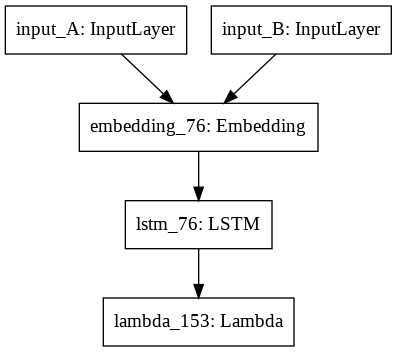

In [ ]:
# check your model
model = build_Siamese(len(tokenizer_x.index_word), MAX_LEN, 128, 256)
print(model.summary())
plot_model(model)

## Loss Function
loss is composed of two terms. One term utilizes the mean of all the non duplicates, the second utilizes the *closest negative*:
 
\begin{align}
 \mathcal{Loss_1(A,P,N)} &=\max \left( -cos(A,P)  + mean_{neg} +\alpha, 0\right) \\
 \mathcal{Loss_2(A,P,N)} &=\max \left( -cos(A,P)  + closest_{neg} +\alpha, 0\right) \\
\mathcal{Loss(A,P,N)} &= mean(Loss_1 + Loss_2) \\
\end{align}

<br>
<img src = "https://www.indellient.com/wp-content/uploads/2020/11/Screen-Shot-2020-11-04-at-1.44.34-PM.png" style="width:1021px;height:229px;"/>


In [ ]:
def TripletLossFn(v1, v2):
    margin=0.25
    # pairwise cosine sim
    scores = tf.matmul(v1, tf.transpose(v2))
    batch_size = len(scores)

    # grab all postive `diagonal` entries in `scores`
    positive = tf.linalg.diag_part(scores)

    # multiply diagonal matrix with 2.0 and subtract it out of `scores` to avoid selecting the 'positive'/green entries, (make them larger negative numbers)
    negative_without_positive = scores - 2.0 * tf.eye(batch_size, dtype=tf.dtypes.float32)

    # take the max value for each row
    closest_negative = tf.reduce_max(negative_without_positive, axis=1)

    # zero out negative sample
    negative_zero_on_duplicate = scores * (1.0 - tf.eye(batch_size, dtype=tf.dtypes.float32))

    # mean negative
    mean_negative = tf.reduce_sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)

    # closest_negative -  positive + margin should less than 0
    triplet_loss1 = tf.maximum(0.0, margin - positive + closest_negative)

    # mean_negative -  positive + margin should less than 0
    triplet_loss2 = tf.maximum(0.0, margin - positive + mean_negative)

    # add the two losses together and take the `fastnp.mean` of it
    triplet_loss = tf.reduce_mean(triplet_loss1 + triplet_loss2)
    return triplet_loss

def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return triplet_loss_fn

## Model Training

In [ ]:
train_generator = tf.data.Dataset.from_tensor_slices(({"input_A": Q1_train_token, "input_B": Q2_train_token}, y_train))
train_generator = train_generator.batch(BATCH_SIZE, drop_remainder=True)

val_generator = tf.data.Dataset.from_tensor_slices(({"input_A": Q1_val_token, "input_B": Q2_val_token}, y_val))
val_generator = val_generator.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
epochs=10
model = build_Siamese(len(tokenizer_x.index_word), MAX_LEN, 128, 256)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=TripletLossFn)
history = model.fit(train_generator, epochs=epochs)

Epoch 1/10


ValueError: ignored

In [ ]:
lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)

def train_model(Siamese, TripletLoss, lr_schedule, train_generator=train_generator, val_generator=val_generator, output_dir='model/'):
    output_dir = os.path.expanduser(output_dir)

    train_task = training.TrainTask(
        labeled_data=train_generator,            # Use generator (train)
        loss_layer=TripletLoss(),                # Use triplet loss. Don't forget to instantiate this object
        optimizer=trax.optimizers.Adam(0.01),    # Don't forget to add the learning rate parameter
        lr_schedule=lr_schedule,                  # Use Trax multifactor schedule function
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator,       # Use generator (val)
        metrics=[TripletLoss()],          # Use triplet loss. Don't forget to instantiate this object
    )
    
    training_loop = training.Loop(Siamese(),
                                  train_task,
                                  eval_task=eval_task,
                                  output_dir=output_dir)

    return training_loop

In [ ]:
train_steps = 5
training_loop = train_model(Siamese, TripletLoss, lr_schedule)
training_loop.run(train_steps)

Step      1: train TripletLoss |  0.49954823
Step      1: eval  TripletLoss |  0.49950948


## Evaluation  

In [ ]:
# Loading in the saved model
model = Siamese()

In [ ]:
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    accuracy = 0

    for i in range(0, len(test_Q1), batch_size):
        q1, q2 = next(data_generator(test_Q1[i:i + batch_size], test_Q2[i:i + batch_size], batch_size, vocab['<PAD>'], shuffle=False))
        y_test = y[i:i + batch_size]
        v1, v2 = model((q1, q2))

        for j in range(batch_size):
            d = np.dot(v1[j], v2[j].T)
            res = d > threshold
            accuracy += (y_test[j] == res)
    # compute accuracy using accuracy and total length of test questions
    accuracy = accuracy / len(test_Q1)
    
    return accuracy

In [ ]:
# this takes around 1 minute
accuracy = classify(Q1_test,Q2_test, y_test, 0.7, model, vocab, batch_size = 512) 
print("Accuracy", accuracy)

Accuracy 0.69091796875


In [ ]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    # use `nltk` word tokenize function to tokenize
    q1 = nltk.word_tokenize(question1)  # tokenize
    q2 = nltk.word_tokenize(question2)  # tokenize
    Q1, Q2 = [], []
    for word in q1:  # encode q1
        # increment by checking the 'word' index in `vocab`
        Q1 += [vocab[word]]
    for word in q2:  # encode q2
        # increment by checking the 'word' index in `vocab`
        Q2 += [vocab[word]]
        
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    v1, v2 = model((Q1, Q2))
    d = np.dot(v1[0], v2[0].T)
    res = d > threshold    
    if(verbose):
        print("Q1  = ", Q1, "\nQ2  = ", Q2)
        print("d   = ", d)
        print("res = ", res)
    return res

In [ ]:
# Feel free to try with your own questions
question1 = "When will I see you?"
question2 = "When can I see you again?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose = True)

Q1  =  [[585  76   4  46  53  21   1   1]] 
Q2  =  [[ 585   33    4   46   53 7280   21    1]]
d   =  0.88113236
res =  True


True

In [ ]:
# Feel free to try with your own questions
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
# 1 means it is duplicated, 0 otherwise
predict(question1 , question2, 0.7, model, vocab, verbose=True)

Q1  =  [[  443  1145  3159  1169    78 29017    21     1]] 
Q2  =  [[  443  1145    60 15302    28    78  7431    21]]
d   =  0.477536
res =  False


False

# Siamese Network 2

## Data Loading

In [ ]:
train_df = pd.read_csv('./data/final_fewshot_train.csv', usecols=['text', 'class'])
test_df = pd.read_csv('./data/final_fewshot_test.csv', usecols=['text', 'class'])
train_df['class'] = train_df['class'].astype('category')
test_df['class'] = test_df['class'].astype('category')
train_df.head()

,text,class
0,[ALLUXIO-2743] Fix failing unit tests,1
1,#2 Refactored structure of Argument,3
2,Remove some features from JwtTokenStore,4
3,Remove duplicated 1.613 section from changelog,2
4,* webapp structure refactoring,3


## Pre-processing

In [ ]:
EMB_DIM = 512
MAX_LEN = 64
BACTH_SIZE = 32

In [ ]:
# load embedding model
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.load(module_url)

In [ ]:
# creating the necessary datastructures for selcting triplets
unique_train_label = np.array(train_df['class'].unique().tolist())
labels_train = np.array(train_df['class'].tolist())
map_train_label_indices = {label: np.flatnonzero(labels_train == label) for label in unique_train_label}

def get_triplets(unique_train_label,map_train_label_indices):
      label_l, label_r = np.random.choice(unique_train_label, 2, replace=False)
      a, p = np.random.choice(map_train_label_indices[label_l], 2, replace=False)
      n = np.random.choice(map_train_label_indices[label_r])
      return a, p, n

def get_triplets_batch(k, train_set, unique_train_label, map_train_label_indices, embed):

    while True:
      idxs_a, idxs_p, idxs_n = [], [], []
      for _ in range(k):
          a, p, n = get_triplets(unique_train_label,map_train_label_indices)
          idxs_a.append(a)
          idxs_p.append(p)
          idxs_n.append(n)

      a = train_set.iloc[idxs_a].values.tolist()
      b = train_set.iloc[idxs_p].values.tolist()
      c = train_set.iloc[idxs_n].values.tolist()

      a = embed(a)
      p = embed(b)
      n = embed(c)

      # return train_set[idxs_a], train_set[idxs_p], train_set[idxs_n]
      yield [a, p, n], []

## Model Buidling

In [ ]:
class TripletLossLayer(tf.keras.layers.Layer):
    '''triple loss layers'''
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = tf.reduce_sum(tf.square(a-p), axis=-1)
        n_dist = tf.reduce_sum(tf.square(a-n), axis=-1)
        return tf.reduce_sum(tf.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def single_model(emb_dim=EMB_DIM):
  input_text1 = tf.keras.layers.Input(shape=(emb_dim, ))
  x = tf.keras.layers.Dense(256, activation='relu')(input_text1)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  dense_layer = tf.keras.layers.Dense(128, name='dense_layer')(x)
  norm_layer = tf.keras.layers.Lambda(lambda  x: tf.nn.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
  model = Model(inputs=[input_text1], outputs=norm_layer)
  return model

In [ ]:
tf.keras.backend.clear_session()
with strategy.scope():
  # siamese network
  embedding_model = single_model()
  in_a = tf.keras.layers.Input(shape=(512, ))
  in_p = tf.keras.layers.Input(shape=(512, ))
  in_n = tf.keras.layers.Input(shape=(512, ))

  # embedding of all inputs
  emb_a = embedding_model(in_a) # (m, 128)
  emb_p = embedding_model(in_p) # (m, 128)
  emb_n = embedding_model(in_n) # (m, 128)

  # triple loss layer
  triplet_loss_layer = TripletLossLayer(alpha=0.4, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
  SNN_model = Model([in_a, in_p, in_n], triplet_loss_layer)
  SNN_model.compile(loss=None, optimizer=tf.keras.optimizers.Adam())

## Model Training

In [ ]:
train_data = get_triplets_batch(BACTH_SIZE, train_df['text'], unique_train_label, map_train_label_indices, embed)
SNN_model.fit(train_data, epochs=100, use_multiprocessing=True, workers=-1, steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 1s 103ms/step - loss: 5.6928
Epoch 2/100
10/10 [==============================] - 1s 105ms/step - loss: 3.1744
Epoch 3/100
10/10 [==============================] - 1s 103ms/step - loss: 3.2582
Epoch 4/100
10/10 [==============================] - 1s 102ms/step - loss: 2.4859
Epoch 5/100
10/10 [==============================] - 1s 101ms/step - loss: 1.9993
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 1.5454
Epoch 7/100
10/10 [==============================] - 1s 104ms/step - loss: 1.5501
Epoch 8/100
10/10 [==============================] - 1s 99ms/step - loss: 1.0298
Epoch 9/100
10/10 [==============================] - 1s 104ms/step - loss: 0.9174
Epoch 10/100
10/10 [==============================] - 1s 103ms/step - loss: 1.1037
Epoch 11/100
10/10 [==============================] - 1s 100ms/step - loss: 0.9097
Epoch 12/100
10/10 [==============================] - 1s 99ms/step - loss: 0.7909
Epoch 13/100
10

## Clustering

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
x_test = embed(np.array(test_df['text'].values.tolist()))

In [ ]:
X_test = embedding_model.predict(x_test)
y_test = np.array(test_df['class'].values.tolist())

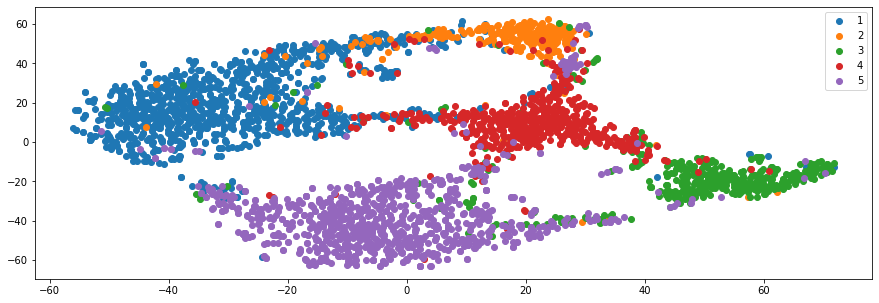

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X_test)
plt.figure(figsize=(15, 5))

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));